# MRF Segmentation via Graph Cuts
An implementation of [Exact Maximum *A Posteriori* Estimation for Binary Images](https://doi.org/10.1111/j.2517-6161.1989.tb01764.x) (D. Greig, B. Porteous and A. Seheult)

Likelihood is modelled using a Gaussian Mixture Model:
$$
\begin{aligned}
    p(y_i|x_i = 0) &= \mathcal{N}(y_i | \mu_0, \sigma_0^2)\\
    p(y_i|x_i = 1) &= \mathcal{N}(y_i | \mu_1, \sigma_1^2)\\
\end{aligned}
$$
$\mathbb{\mu}, \mathbb{\sigma}$ are the likelihood/noise parameters which need to be optimized (while keeping $x$ fixed)
$$
\begin{aligned}
    \text{argmax}_{\theta} p(x|y, \theta) = \text{argmax}_{\theta} p(y|x)p(x) = \text{argmax}_{\theta} p(y|x)\\
\end{aligned}
$$
Since we have a gaussian model for the likelihood, these estimates will simply be the class mean and the class standard deviation.  
Rest of the details are same as that in the paper.

In [62]:
%reset -f

In [63]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# For graph related operations
import networkx as nx
from networkx.algorithms.flow import minimum_cut

In [64]:
np.random.seed(0) # To ensure reproducibility

## Functions

In [65]:
def gaussian(Y, mu, sigma):
    """ Computes the Gaussian PDF at all points in Y """
    num = np.exp(-0.5 * (((Y - mu) / sigma)**2))
    den = np.sqrt(2 * np.pi)*sigma
    return num / den

In [66]:
def LLR(Y, mu, sigma):
    """ Returns the log-likelihood ratio for all pixels (This is independant of X, but depends on mu and sigma) """
    num = gaussian(Y, mu[1], sigma[1])
    den = gaussian(Y, mu[0], sigma[0])
    return np.log(num / den)

In [67]:
def getNeighbors(i, j, R, C):
    """ Returns the 8 neighbours for the pixel (i, j) without wrap-around """
    neighbors = []
    d = [-1, 0, 1]
    for sx in d:
        for sy in d:
            if not (sx == 0 and sy == 0):
                n = [i + sx, j + sy]
                if (C-1 >= n[0] >= 0) and (R-1 >= n[1] >= 0):
                    neighbors.append(n)
    return neighbors

In [68]:
def buildG(Y, beta, mu, sigma):
    """ Returns the graph as specified in the paper """

    G = nx.DiGraph() # Empty directed graph
    G.add_node("s") # The source node
    G.add_node("t") # The destination node

    R, C = Y.shape

    llr = LLR(Y, mu, sigma) 

    for i in range(R):
        for j in range(C):

            node = "({}, {})".format(i, j)

            # The first set of edges
            if llr[i, j] > 0:
                G.add_edge("s", node, capacity = llr[i, j])

            # The second set of edges
            else:
                G.add_edge(node, "t", capacity = -1*llr[i, j])

            # The thirds set of edges
            neighbors = getNeighbors(i, j, R, C)
            for n in neighbors:
                n_node = "({}, {})".format(n[0], n[1])
                G.add_edge(node, n_node, capacity = beta)

    return G

In [69]:
def cutG(g):
    """ Computes the min-cut value and the corresponding cut """
    cut_val, partition = minimum_cut(g, "s", "t")
    S, T = partition
    S.remove("s")
    T.remove("t")
    S = list(S)
    T = list(T)
    return cut_val, S, T

In [70]:
def updateSeg(S, T, R, C):
    """ Updates the segmented image using the obtaind s-t cut """
    X = np.zeros([R, C])
    for s in S:
        pixel = eval(s)
        X[pixel] = 1.  
    for t in T:
        pixel = eval(t)
        X[pixel] = 0. 
    return X

In [71]:
def updateNoiseParams(Y, X):
    """ Returns the updated likelihood/noise parameters mu and sigma using the segmented image X """

    mu = np.array([0., 0.])
    sigma = np.array([0., 0.])

    mask_0 = (X == 0.)
    y0 = Y[mask_0]
    mu[0] = y0.mean()
    sigma[0] = y0.std()

    mask_1 = (X == 1.)
    y1 = Y[mask_1]
    mu[1] = y1.mean()
    sigma[1] = y1.std()

    return mu, sigma

In [72]:
def optimize(Y, X, mu, sigma, beta, N_iters, eps = 1e-5):
    """ Runs the algorithm and returns the optimized values """

    R, C = Y.shape

    loss = []
    for i in range(N_iters):

        # Build the graph
        g = buildG(Y, beta, mu, sigma)
        
        # Get the partitions
        cut_val, S, T = cutG(g)
        loss.append(cut_val)
        
        # Stopping condition
        if i > 2 and (abs(loss[-1] - loss[-2])/loss[-2] <= eps or loss[-1] > loss[-2]):
            break

        # Update the segmentation
        X = updateSeg(S, T, R, C)

        # Update the noise parameters
        mu, sigma = updateNoiseParams(Y, X)

    return X, mu, sigma, loss

### General Functions

In [73]:
def disp(img):
    """ Displays the grayscale image """
    plt.imshow(img, cmap = "gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [74]:
def scale(img):
    """ Scales the image in the range [0, 1] """
    img_01 = (img - np.min(img))/np.ptp(img)
    return img_01

In [75]:
def load(path, shape):
    """ Loads the image at the given path as a grayscale image, resizes it, scales it, and returns it """
    img = cv2.imread(path, 0)
    img = cv2.resize(img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)
    img = scale(img)
    return img

In [76]:
def addNoise(img, sigma_noise = 0.25):
    """ Adds gaussian noise to the image """
    noise = sigma_noise * np.random.normal(0, 1, img.shape)
    img = img + noise
    img = scale(img)
    return img

In [77]:
def threshold(img, thresh = 0.5):
    """ Binary thresholding, used to get the initial segmentation """
    img = img > thresh
    img = img.astype(float)
    return img

## Main

In [78]:
# Constants
PATH_IMG = "img.jpg"
SHAPE = [256, 256]

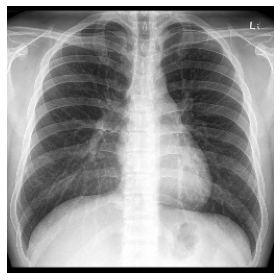

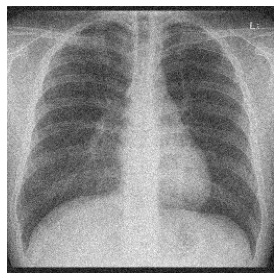

In [79]:
img = load(PATH_IMG, SHAPE)
disp(img)

img = addNoise(img, sigma_noise = 0.075)
disp(img)

### Initial Estimates

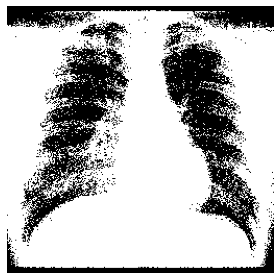

In [80]:
X_init = threshold(img, thresh = 0.4)
disp(X_init)

In [81]:
mu_init, sigma_init = updateNoiseParams(img, X_init)

### Optimization

In [86]:
beta = 1 # Value of the constant pairwise interaction as specified in the paper
max_iters = 5
eps = 1e-4

X, mu, sigma, loss = optimize(img, X_init, mu_init, sigma_init, beta, max_iters, eps) # ~ 2.5 mins for a 256x256 image

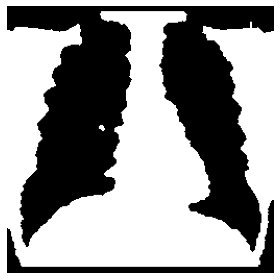

In [87]:
disp(X)

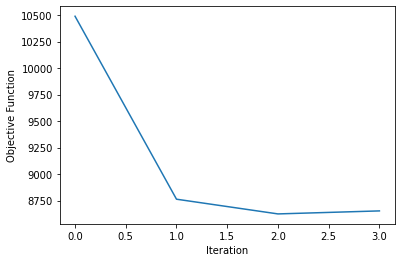

In [89]:
plt.plot(range(len(loss)), loss)
plt.xlabel("Iteration")
plt.ylabel("Objective Function")
plt.show()